In [ ]:
# REF: 7.3 使用scikit-leran提供的隨機森林處理迴歸問題(RandomForestRegressor).ipynb

In [4]:
def simulate(data, preds):
    # 常數與暫存變數
    buy_threshold = 0.5
    stake = 100

    true, pred, balances = [], [], []

    buy_price = 0
    buy_points, sell_points = [], []
    balance = 0

    start_index = len(data) - len(preds) - 1

    # 計算預測值
    for i in range(len(preds)):
        # 昨日收盤價
        last_close = data.Close[i+start_index-1]
        # 今日收盤價
        current_close = data.Close[i+start_index]

        # 儲存今日收盤價
        true.append(current_close)
        # 儲存今日預測收盤價
        # 使用昨日收盤價跟模型預測的變化百分比換算而得
        pred.append(last_close*(1+preds[i]/100))


        # 根據預測進行交易
        # 預測會漲價並且手上沒有比特幣
        if preds[i] > buy_threshold and buy_price == 0:
            buy_price = true[-1]
            buy_points.append(i)

        # 預測會下跌且手上持有比特幣
        elif preds[i] < -buy_threshold and not buy_price == 0:
            profit = (current_close - buy_price) * stake / buy_price
            balance += profit
            buy_price = 0
            sell_points.append(i)

        balances.append(balance)


    true = np.array(true)
    pred = np.array(pred)

    # 繪製圖表
    plt.figure(figsize = (8, 8))
    plt.scatter(buy_points, true[buy_points]+500, 
                marker='x', label = "buy")
    plt.scatter(sell_points, true[sell_points]-500, 
                marker='o', label = "sell", s = 5)
    plt.plot(true, label = 'True', c = 'red')
    plt.plot(pred, label = 'pred', linestyle = '--', 
             c = 'black')
    plt.title('Trades')
    plt.legend()
    plt.show()

    plt.figure(figsize = (8, 8))
    plt.plot(balances)
    plt.title('Profit')
    plt.show()
    print('MSE: %.2f'%metrics.mean_squared_error(true, pred))
    balance_df = pd.DataFrame(balances)

    pct_returns = balance_df.diff()/stake
    pct_returns = pct_returns[pct_returns != 0].dropna()


    print('Sharpe: %.2f'%(np.mean(pct_returns)/np.std(pct_returns)))


In [5]:
def create_x_data(lags=1):
    diff_data = np.zeros((diff_len, lags))

    for lag in range(1, lags+1):
        this_data = diffs[:-lag]
        diff_data[lag:, lag-1] = this_data

    return  diff_data

In [6]:
def create_extend_x_data(lags=1):
    diff_data = np.zeros((diff_len, lags))
    ma_data = np.zeros((diff_len, lags))
    # 新增15天移動平均值
    diff_ma = (data.Close.diff()/
               data.Close.shift(periods = 1, fill_value = 0)).rolling(15).mean().fillna(0).values[1:]
    for lag in range(1, lags+1):
        this_data = diffs[:-lag]
        diff_data[lag:, lag-1] = this_data

        this_data = diff_ma[:-lag]
        ma_data[lag:, lag-1] = this_data
    return np.concatenate((diff_data, ma_data), axis=1)

In [7]:
# 第 1 部分
# 載入函式庫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 載入資料集
np.random.seed(123456)
data = pd.read_csv('../Data/BTC-USD.csv')

# 特徵工程
# 刪除資料中的缺失值
data = data.dropna()
# 將UTC時間轉成年月日
data['Date'] = pd.to_datetime(data['Date'])
# 將時間設定為索引
data.set_index('Date', drop=True, inplace=True)
diffs = (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values[1:]
diff_len = len(diffs)

In [8]:
# 第 2 部分
# 建立模型
lr = RandomForestRegressor(n_jobs=5)

In [9]:
# 第 3 部分
# 建立特徵
x_data = create_x_data(lags=20)*100
y_data = diffs*100

x_data = np.around(x_data, decimals=8)
y_data = np.around(y_data, decimals=8)

Percentages MSE: 16.40


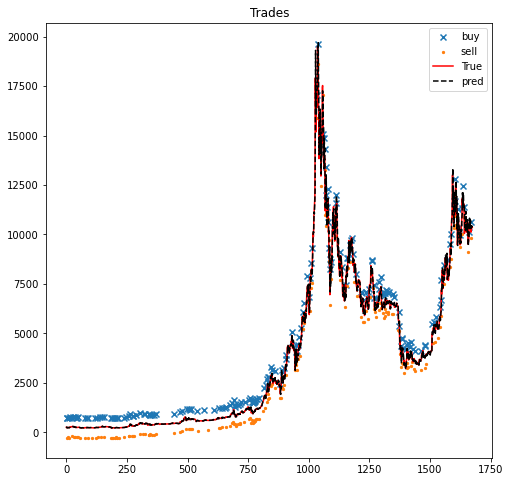

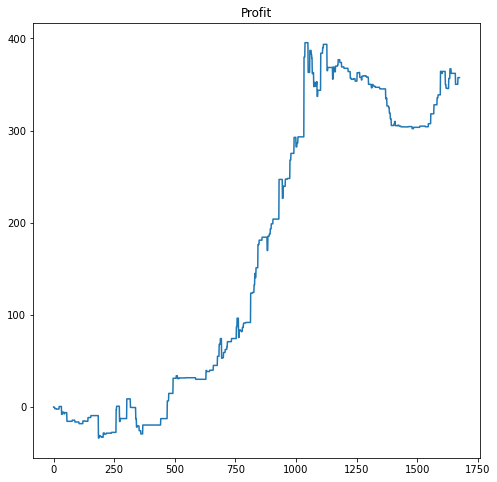

MSE: 90433.40
Sharpe: 0.16


In [10]:
# 第 4 部分
# 訓練模型
window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))


print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)

Percentages MSE: 15.56


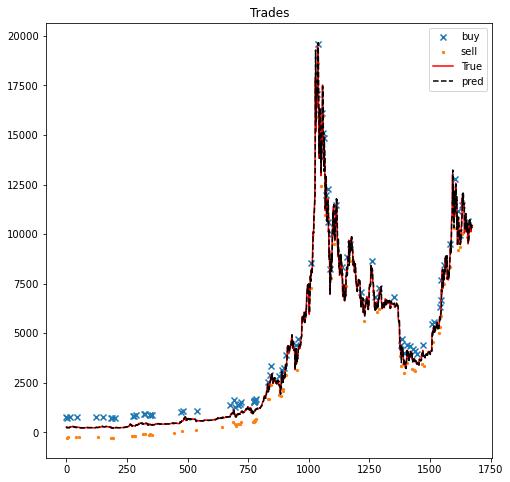

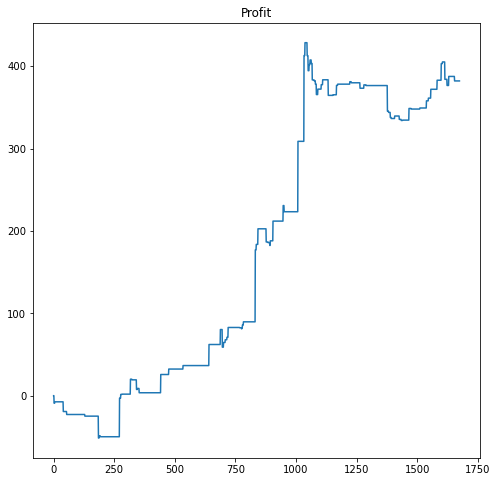

MSE: 90553.12
Sharpe: 0.21


In [11]:
# 第 5 部分
# 改進模型:限制每顆樹的最大深度為3

lr = RandomForestRegressor(max_depth=3,
                           n_jobs=5)
# 訓練模型
window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))

print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)

Percentages MSE: 15.39


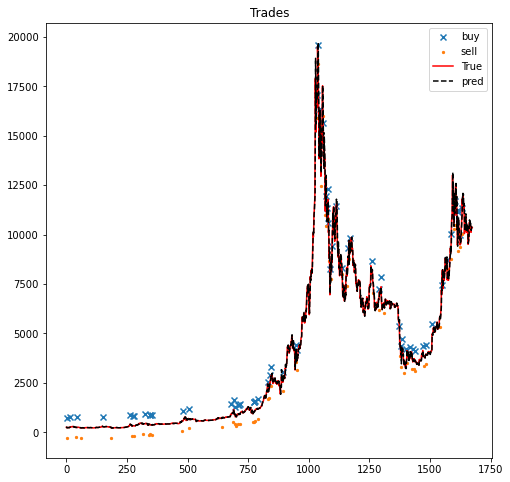

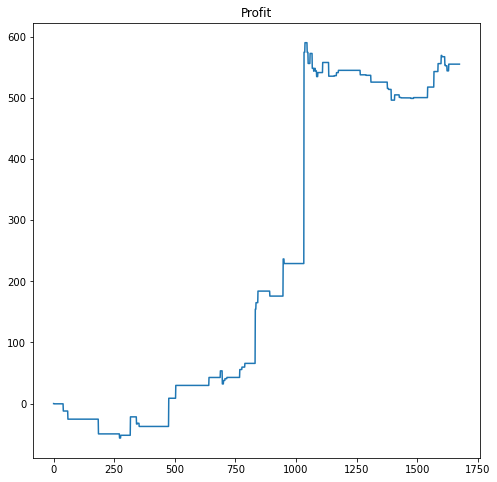

MSE: 86680.58
Sharpe: 0.19


In [12]:
# 改進模型:限制每顆樹的最大深度為2

lr = RandomForestRegressor(max_depth=2,
                           n_jobs=5)
# 訓練模型
window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))


print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)

Percentages MSE: 15.32


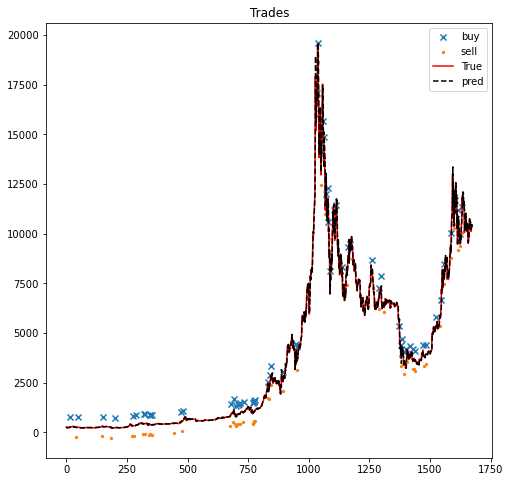

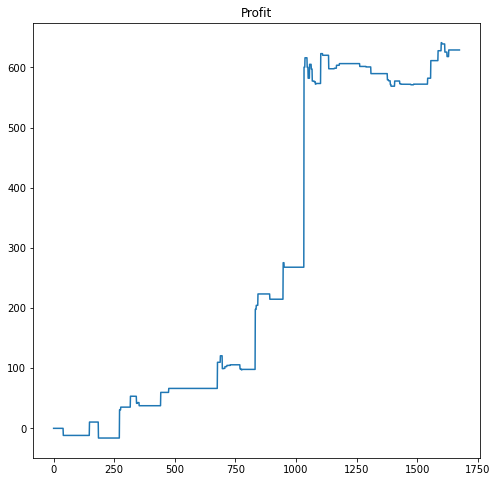

MSE: 86740.57
Sharpe: 0.21


In [13]:
# 改進模型:限制每顆樹的最大深度為2 & 基學習器由預設值100調高到150

lr = RandomForestRegressor(n_estimators = 150,  # 指定基學習器的數量
                           max_depth=2,
                           n_jobs=5)

window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))


print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)

Percentages MSE: 16.46


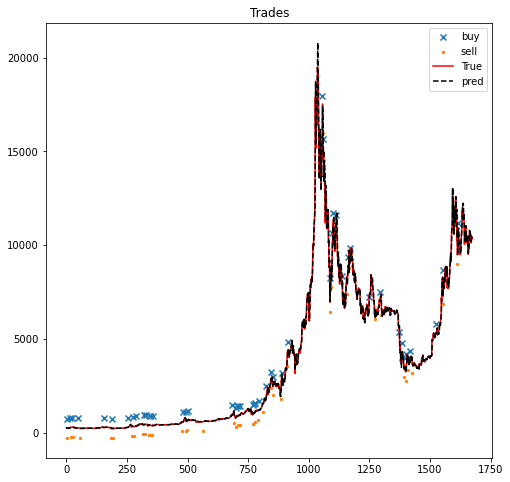

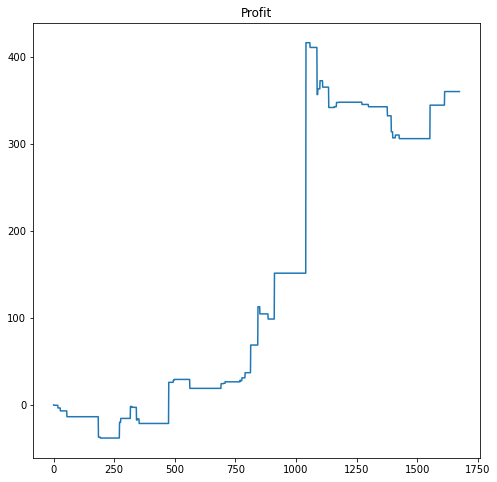

MSE: 86901.34
Sharpe: 0.18


In [14]:
x_data = create_extend_x_data(lags=30)*100
y_data = diffs*100

x_data = np.around(x_data, decimals=8)
y_data = np.around(y_data, decimals=8)

lr = RandomForestRegressor(n_estimators = 150,
                           max_depth=2,
                           n_jobs=5)

window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))


print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)
